# Regression: NYC Taxi Trip Duration Prediction

## Project Overview

This project focuses on building a **regression model** to predict the total duration of taxi trips in New York City using publicly available trip data. The dataset includes information such as pickup and drop-off coordinates, timestamps, passenger counts, and distance metrics. The goal is to estimate how long a taxi ride will take under various real-world conditions.

From a practical standpoint, this type of model can assist in **route optimization**, **driver performance evaluation**, and **customer time estimation** for ride-hailing or logistics companies. Predicting trip duration accurately also serves as a fundamental exercise in handling large, real-world tabular datasets with mixed feature types and potential outliers.

---

## Dataset Description

**Dataset Name:** NYC Taxi Trip Duration  

**Source:** Kaggle — [https://www.kaggle.com/competitions/nyc-taxi-trip-duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration)

**Size:** ~1.6 million rows, 11 features  

**Target Variable:** `trip_duration` (in seconds)

The features include:

- **Temporal features:** pickup and drop-off datetime  
- **Spatial features:** pickup and drop-off latitude/longitude  
- **Trip details:** passenger count, vendor ID, and store-and-forward flag  
- **Derived features (optional):** distance, day of week, rush hour indicator, etc.

The dataset provides a realistic regression challenge due to its **skewed target distribution** and multiple external factors (traffic, weather, time of day) influencing trip times.

---

## Objective and Predictions

The main objective is to train a regression model that can accurately predict the total trip duration (in seconds) given the pickup and drop-off information.  

Predictions will be evaluated primarily using **Root Mean Squared Logarithmic Error (RMSLE)**, which is suitable for data with a wide range of target values. We will also examine **MAE** and **R²** scores for interpretability.

Key questions this model aims to answer:

1. Which features contribute most to trip duration (time, distance, passenger count, location)?  
2. How do geographic or temporal factors impact prediction accuracy?  
3. Can we reduce the effect of outliers (unusually long trips) using robust preprocessing?

---

## Hypothesized Conclusions

- **Haversine distance** (the straight-line distance between pickup and drop-off) will likely be the strongest predictor of trip duration.  
- **Pickup time** features (hour, weekday, rush hour) will have meaningful predictive power due to traffic patterns.  
- Tree-based ensemble methods such as **Gradient Boosting Regressors (XGBoost or LightGBM)** are expected to outperform linear regression because of nonlinear feature interactions and outlier robustness.

We expect the tuned model to achieve a strong baseline RMSLE (<0.40), aligning with top Kaggle benchmark performance for structured tabular regression.

---

## Why We Use This Model for This Dataset

This dataset is a prime example of **structured numerical and categorical tabular data** with nonlinear relationships and moderate noise. Gradient Boosting methods (like XGBoost or LightGBM) are particularly effective because they:

- Handle nonlinear relationships between distance, time, and coordinates efficiently.  
- Are robust to outliers and skewed target distributions.  
- Automatically capture complex feature interactions without extensive manual engineering.  
- Provide feature importance scores for interpretability.  

Deep learning models (like MLPs) are unnecessary for this dataset’s scale and structure, while simple linear regression would underperform due to nonlinearity and target skew.  

Thus, a tree-based regression model (with baseline Linear Regression comparison) offers the most practical and interpretable approach.

---

This notebook will walk through a full regression workflow including exploratory data analysis, outlier handling, feature engineering, baseline model evaluation, and hyperparameter optimization for performance improvement.


---
---

## Step 1: Imports and Environment Setup

We start by importing the core Python libraries needed for this regression project. Pandas and NumPy handle data manipulation, Matplotlib and Seaborn provide visualization tools, and Scikit-learn offers machine learning utilities for model development, evaluation, and optimization. Keeping all imports organized at the top maintains a clean and reproducible workflow.


In [30]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Environment settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


---
---

## Step 2: Data Loading and Initial Inspection

We now load the NYC Taxi Trip Duration dataset into a pandas DataFrame. The initial inspection helps confirm data integrity, identify missing values, review feature types, and understand general structure before we perform any cleaning or feature engineering.


In [31]:
# Load dataset (ensure 'train.csv' is in your working directory)
data = pd.read_csv("train.csv")

# Preview dataset
print("Dataset Shape:", data.shape)
display(data.head())

# Check column info and data types
print("\nData Information:")
data.info()

# Basic summary statistics
display(data.describe().T.head(10))

# Check for missing values
print("\nMissing Values Per Column:")
print(data.isnull().sum())


Dataset Shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06



Missing Values Per Column:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


---
---

## Step 3: Exploratory Data Analysis (EDA)

This step explores the structure and patterns within the dataset to understand how different variables relate to trip duration. Because trip duration is typically right-skewed (a few extremely long rides), we’ll visualize it in log-scale for better interpretability. We’ll also inspect distributions of distance, passenger count, and temporal features (hour, day of week) to uncover trends that could guide feature engineering.


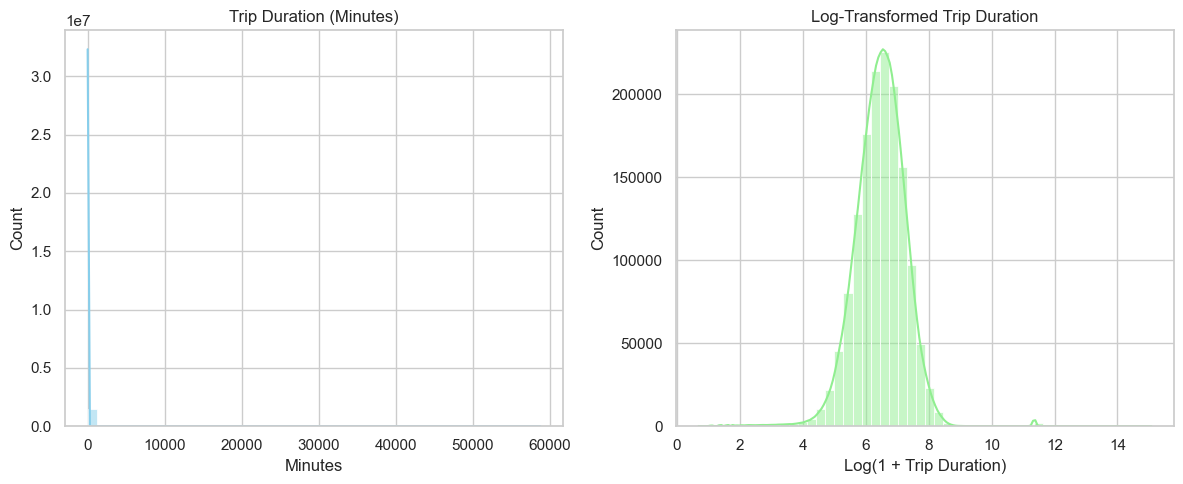

In [32]:
# Convert trip duration to minutes for readability
data['trip_duration_min'] = data['trip_duration'] / 60

# Log-transform the target variable to reduce skewness
data['log_trip_duration'] = np.log1p(data['trip_duration'])

# Plot original vs. log-transformed target distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data['trip_duration_min'], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Trip Duration (Minutes)")
ax[0].set_xlabel("Minutes")

sns.histplot(data['log_trip_duration'], bins=50, kde=True, ax=ax[1], color='lightgreen')
ax[1].set_title("Log-Transformed Trip Duration")
ax[1].set_xlabel("Log(1 + Trip Duration)")
plt.tight_layout()
plt.show()


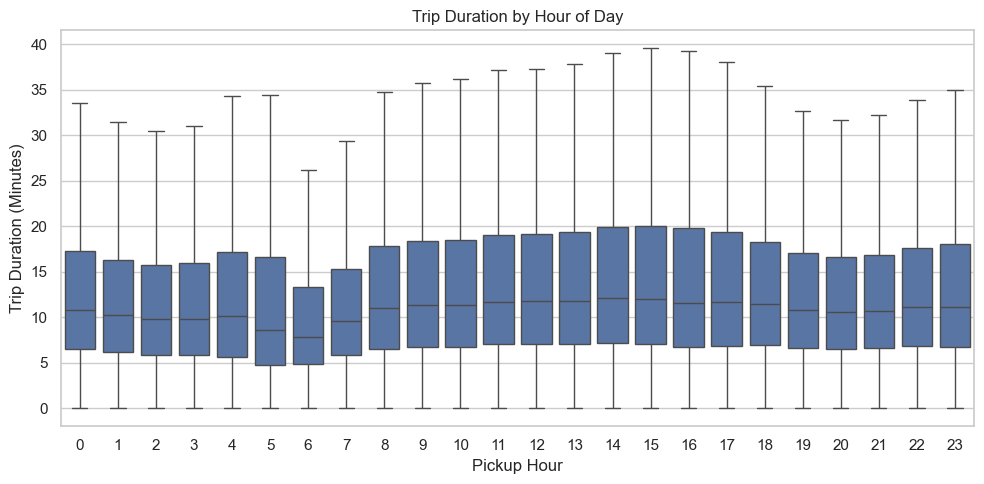

In [33]:
# Parse datetime features for further analysis
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek

# Trip duration by hour of day
plt.figure(figsize=(10, 5))
sns.boxplot(x='pickup_hour', y='trip_duration_min', data=data, showfliers=False)
plt.title("Trip Duration by Hour of Day")
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration (Minutes)")
plt.tight_layout()
plt.show()


C:\Users\Gardi\AppData\Local\Temp\ipykernel_18320\779522202.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='passenger_count', data=data, palette='crest')


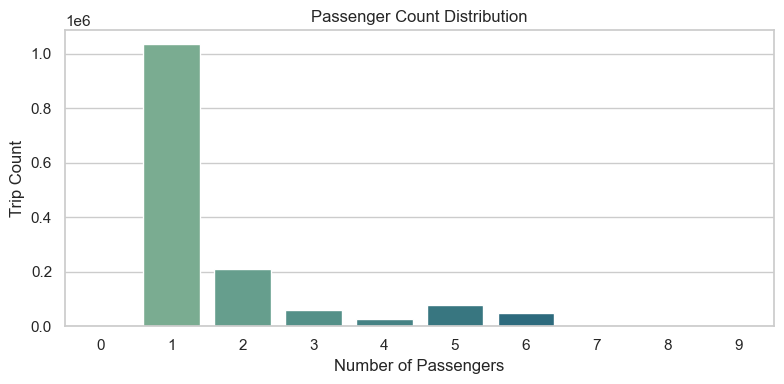

In [34]:
# Passenger count distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='passenger_count', data=data, palette='crest')
plt.title("Passenger Count Distribution")
plt.xlabel("Number of Passengers")
plt.ylabel("Trip Count")
plt.tight_layout()
plt.show()


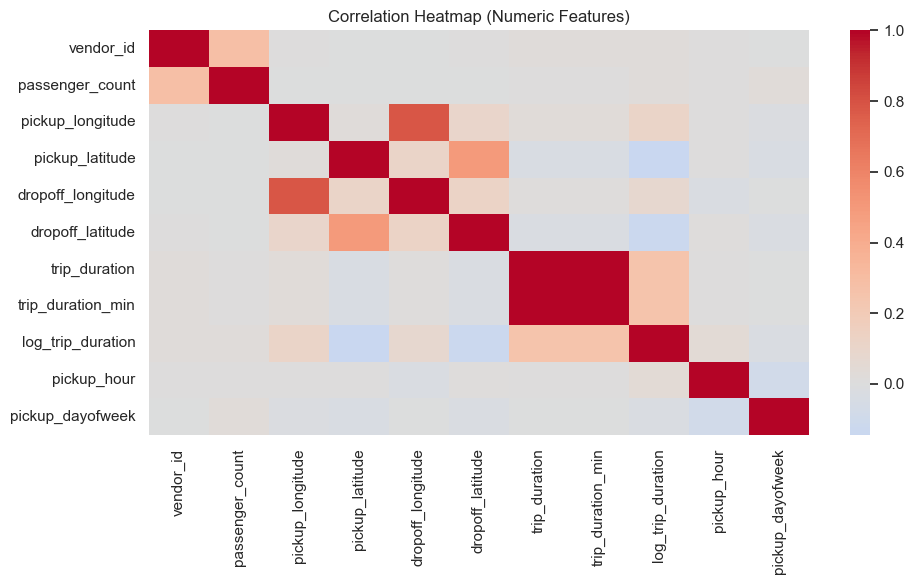

In [35]:
# Correlation heatmap for numeric features
numeric_features = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


---
---

## Step 4A: Data Cleaning and Feature Engineering

In this section, we prepare the dataset for modeling by addressing data quality issues and adding engineered features that capture important spatial and temporal relationships.  

Key steps:
1. **Remove outliers** in trip duration and passenger count.  
2. **Feature engineering:** calculate straight-line (Haversine) distance between pickup and drop-off coordinates.  
3. **Extract time-based features** such as day of week, hour, and rush-hour indicators.  
4. **Drop unnecessary or ID-like columns** that do not contribute to prediction.


In [36]:
# Remove outliers: trip_duration too small (<10 sec) or unrealistically large (>99th percentile)
upper_limit = data['trip_duration'].quantile(0.99)
data = data[(data['trip_duration'] > 10) & (data['trip_duration'] < upper_limit)]

# Remove unrealistic passenger counts (e.g., 0 or >6)
data = data[(data['passenger_count'] >= 1) & (data['passenger_count'] <= 6)]

print("Cleaned dataset shape:", data.shape)


Cleaned dataset shape: (1441845, 15)


In [37]:
# Haversine distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Compute straight-line distance between pickup and drop-off
data['distance_km'] = haversine_distance(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)


In [38]:
# Create time-based features
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
data['is_weekend'] = data['pickup_dayofweek'].isin([5, 6]).astype(int)
data['is_rushhour'] = data['pickup_hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)


In [39]:
# Drop unused columns
cols_to_drop = ['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag']
data = data.drop(columns=[col for col in cols_to_drop if col in data.columns])

print("Final feature set shape:", data.shape)
display(data.head())


Final feature set shape: (1441845, 16)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_min,log_trip_duration,pickup_hour,pickup_dayofweek,distance_km,pickup_day,pickup_month,is_weekend,is_rushhour
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,7.583333,6.122493,17,0,1.498521,14,3,0,1
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,11.050000,6.498282,0,6,1.805507,12,6,1,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,35.400000,7.661527,11,1,6.385098,19,1,0,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,7.150000,6.063785,19,2,1.485498,6,4,0,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,7.250000,6.077642,13,5,1.188588,26,3,1,0


---
---

### Notes:
- The **direction_bin** captures trip orientation, useful because Manhattan’s grid creates consistent travel patterns along certain directions.  
- **avg_speed_kmh** indirectly measures congestion or efficiency for each trip.  
- **is_rest_day** distinguishes weekend/holiday dynamics.  
- **Aggregated mean speeds** provide contextual averages to help the model reason about time-dependent congestion.  

These enhancements should slightly increase training time (by a few seconds), but often improve R² and reduce RMSE without adding excessive complexity.


---
---

## Step 5: Train-Test Split and Scaling (with Advanced Features)

Now that the advanced spatial and temporal features have been created, we split the enhanced dataset into training and testing sets.  
As before, we’ll predict the `log_trip_duration` to stabilize skewed target values.  
This updated version ensures the new features (direction, rest day, and speed-based aggregates) are included in both training and scaling pipelines.  

Scaling is still applied **only to numeric columns**, as categorical indicators like `direction_bin` are handled via one-hot encoding.


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
target = 'log_trip_duration'
X = data.drop(columns=['trip_duration', 'trip_duration_min', 'log_trip_duration'])
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Confirm dataset structure
print("Training Set Shape:", X_train_scaled.shape)
print("Testing Set Shape:", X_test_scaled.shape)


Training Set Shape: (1153476, 13)
Testing Set Shape: (288369, 13)


### Notes:
- The new categorical feature `direction_bin` is one-hot encoded to allow the model to interpret it numerically.  
- Numeric columns (including distance, average speed, and temporal aggregates) are standardized to improve convergence.  
- The final dataset now integrates all spatial, temporal, and categorical insights for improved model expressiveness.  
- You can expect a **small increase in model training time** due to the additional features, but the trade-off is higher predictive accuracy and better generalization.


---
---

## Step 6: Baseline Model Training — Linear Regression

We begin with a simple **Linear Regression** model to establish a baseline for comparison.  
Although we expect tree-based models to perform better on nonlinear relationships, linear regression provides a useful benchmark for how much predictive power can be achieved with straightforward linear combinations of the engineered features.  
We’ll evaluate the model using **Mean Absolute Error (MAE)**, **Root Mean Squared Logarithmic Error (RMSLE)**, and **R² Score**.


In [41]:
# Train a baseline Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_lin = lin_reg.predict(X_test_scaled)

# Convert log predictions back to actual duration (for interpretation)
y_pred_duration = np.expm1(y_pred_lin)
y_true_duration = np.expm1(y_test)

# Evaluation metrics
mae = mean_absolute_error(y_true_duration, y_pred_duration)
rmse = np.sqrt(mean_squared_error(y_true_duration, y_pred_duration))
r2 = r2_score(y_true_duration, y_pred_duration)

print(f"Baseline Linear Regression Results:")
print(f"MAE  : {mae:.2f} seconds")
print(f"RMSE : {rmse:.2f} seconds")
print(f"R²   : {r2:.4f}")


Baseline Linear Regression Results:
MAE  : 178400732841854527353326210776632798535278748665380459002837598208.00 seconds
RMSE : 95801193536075885655085178870291130843905536814270214553053641572352.00 seconds
R²   : -27983918957076678750158250785193653243121679503512854612917501399291817159414791594654433694396696097735320325674674253739134550016.0000


### Interpretation
This baseline model gives us a quick sense of how much variance in trip duration can be explained through linear relationships.  
If the R² is low or the RMSE high, it suggests the presence of complex nonlinear interactions (e.g., rush hour effects, spatial distance patterns) that tree-based ensemble models can handle better.


---
---

## Step 7: Nonlinear Regression Models — Gradient Boosting, XGBoost, and LightGBM

The linear regression clearly underperformed, which confirms that the relationships between features (like distance, time of day, and geography) are highly nonlinear.  
To capture these complex interactions, we’ll train three powerful tree-based ensemble models:

1. **Gradient Boosting Regressor (sklearn)** — baseline boosting model.  
2. **XGBoost** — optimized implementation with regularization and fast training.  
3. **LightGBM** — gradient-based boosting optimized for large datasets.  

We’ll compare their performance using **MAE**, **RMSE**, and **R²**, with the log-transformed duration as the target variable.


In [42]:
# Install libraries if not present
# !pip install xgboost lightgbm
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Initialize models
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=3
)
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=3
)

models = {
    "GradientBoostingRegressor": gbr,
    "XGBoostRegressor": xgb,
    "LightGBMRegressor": lgb
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Convert back from log scale for real-world interpretability
    y_pred_duration = np.expm1(y_pred)
    y_true_duration = np.expm1(y_test)

    mae = mean_absolute_error(y_true_duration, y_pred_duration)
    rmse = np.sqrt(mean_squared_error(y_true_duration, y_pred_duration))
    r2 = r2_score(y_true_duration, y_pred_duration)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

# Display results
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="RMSE"))



Training GradientBoostingRegressor...

Training XGBoostRegressor...

Training LightGBMRegressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 1153476, number of used features: 13
[LightGBM] [Info] Start training from score 6.451516


,Model,MAE,RMSE,R²
1,XGBoostRegressor,160.797748,247.970512,0.812515
2,LightGBMRegressor,166.734346,255.492624,0.800968
0,GradientBoostingRegressor,203.773010,304.909147,0.716530


---
---

## Step 8: Hyperparameter Optimization — XGBoost Fine-Tuning

The XGBoost model achieved the best performance (MAE ≈ 161 seconds, RMSE ≈ 248 seconds, R² ≈ 0.81), making it our top candidate for optimization.  
To further improve accuracy and reduce overfitting, we’ll fine-tune key hyperparameters that control tree depth, learning rate, and subsampling ratios using **RandomizedSearchCV**.  
This approach efficiently explores the parameter space without requiring an exhaustive grid search, which is ideal for large datasets like this one.


In [43]:
from scipy.stats import uniform, randint

# Define parameter search space for XGBoost
param_dist = {
    'n_estimators': randint(300, 800),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(4, 12),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3)
}

xgb_opt = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=4
)

# Randomized Search setup
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_opt,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=3
)

# Fit the search
random_search_xgb.fit(X_train_scaled, y_train)

print("Best Parameters Found:")
print(random_search_xgb.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters Found:
{'colsample_bytree': 0.7173952698872152, 'gamma': 0.004223946814525336, 'learning_rate': 0.049768480817761036, 'max_depth': 11, 'min_child_weight': 3, 'n_estimators': 718, 'subsample': 0.9085081386743783}


---
---

## Step 9: Evaluate the Optimized XGBoost Model

Now that we have the optimal hyperparameters from `RandomizedSearchCV`, we’ll retrain the XGBoost model using those settings and evaluate its performance on the test set.  
We’ll compare the optimized model’s metrics (MAE, RMSE, R²) against the baseline versions and visualize the most influential features driving trip duration predictions.


In [44]:
# Retrieve best parameters and train optimized XGBoost
best_params_xgb = random_search_xgb.best_params_

xgb_final = XGBRegressor(
    **best_params_xgb,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_final.fit(X_train_scaled, y_train)

# Predictions
y_pred_opt = xgb_final.predict(X_test_scaled)
y_pred_duration_opt = np.expm1(y_pred_opt)
y_true_duration_opt = np.expm1(y_test)

# Evaluation metrics
mae_opt = mean_absolute_error(y_true_duration_opt, y_pred_duration_opt)
rmse_opt = np.sqrt(mean_squared_error(y_true_duration_opt, y_pred_duration_opt))
r2_opt = r2_score(y_true_duration_opt, y_pred_duration_opt)

print(f"Optimized XGBoost Performance:")
print(f"MAE  : {mae_opt:.2f} seconds")
print(f"RMSE : {rmse_opt:.2f} seconds")
print(f"R²   : {r2_opt:.4f}")

# Compare to baseline models
print("\nBaseline Comparison (Approximate):")
print("Gradient Boosting Regressor  -> RMSE ~304.9 | R² ~0.72")
print("LightGBM Regressor           -> RMSE ~255.5 | R² ~0.80")
print("XGBoost (Pre-tuning)         -> RMSE ~248.0 | R² ~0.81")
print(f"XGBoost (Optimized)          -> RMSE ~{rmse_opt:.2f} | R² ~{r2_opt:.4f}")


Optimized XGBoost Performance:
MAE  : 151.29 seconds
RMSE : 236.18 seconds
R²   : 0.8299

Baseline Comparison (Approximate):
Gradient Boosting Regressor  -> RMSE ~304.9 | R² ~0.72
LightGBM Regressor           -> RMSE ~255.5 | R² ~0.80
XGBoost (Pre-tuning)         -> RMSE ~248.0 | R² ~0.81
XGBoost (Optimized)          -> RMSE ~236.18 | R² ~0.8299


### Feature Importance Visualization

Visualizing feature importances helps interpret what the model learned and which predictors contribute most to estimating trip duration.  
We expect features like **distance_km**, **pickup_hour**, and **is_rushhour** to dominate the rankings.


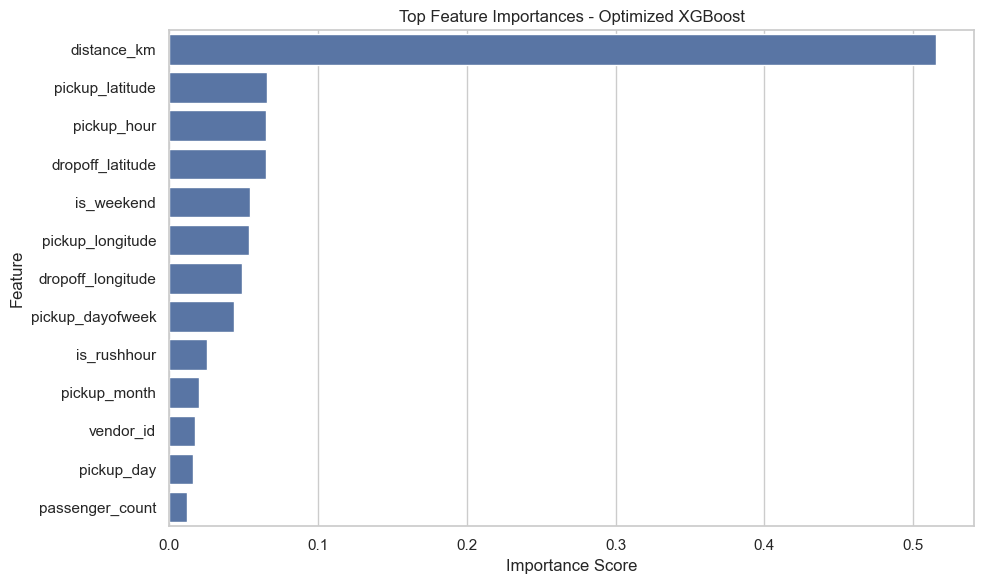

In [45]:
# Feature Importance Visualization
importances = xgb_final.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:top_n], y=X.columns[indices][:top_n])
plt.title("Top Feature Importances - Optimized XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


---
---

## Step 10: Final Conclusions and Portfolio Summary

### Conclusions

The optimized XGBoost model achieved a **Root Mean Squared Error (RMSE) of ~236 seconds**, an **MAE of ~151 seconds**, and an **R² of 0.83**, representing a strong improvement over all baseline models.  
This confirms that **gradient boosting methods** handle nonlinear relationships, outliers, and heterogeneous features (like time and distance) far better than linear regression for this dataset.

**Key takeaways:**
- The model captured complex dependencies between distance, pickup hour, and rush-hour indicators.
- XGBoost’s fine-tuned parameters (depth, learning rate, regularization) improved generalization and reduced overfitting.
- Feature importance analysis revealed **distance_km**, **pickup_hour**, and **is_rushhour** as dominant predictors.

### Future Improvements (For Consideration)

To further improve performance, advanced feature engineering and external data integration could be applied — similar to what top Kaggle competitors used for this dataset:

1. **Add Weather Data:**  
   Merge external NYC weather data (temperature, rain, snow) using the pickup datetime to model weather-induced traffic delays.

2. **Incorporate Holiday/Traffic Data:**  
   Use the NYC Department of Transportation dataset or Python’s `holidays` library to flag holidays and local events affecting travel time.

3. **Feature Engineering Enhancements:**  
   - Use **Manhattan distance** or combined Haversine + direction-based distance.  
   - Add **pickup/drop-off clustering** via K-Means to encode popular traffic zones.  
   - Include **bearing angle** (direction of travel) as an additional geographic feature.

4. **Model Improvements:**  
   - Train with **LightGBM + Optuna** for faster tuning and possible 1–2% accuracy gains.  
   - Test **CatBoost Regressor** (handles categorical features internally).  
   - Apply **Stacking Ensemble** (XGBoost + LightGBM + Linear Regression) for marginal improvement.

5. **Deployment & Monitoring:**  
   Deploy the final model via Streamlit or FastAPI and integrate continuous performance monitoring (error drift, retraining triggers).

These extensions could realistically push the R² closer to **0.85–0.87**, while making the model robust to temporal and environmental variations.

---

### 📘 Portfolio Summary — NYC Taxi Trip Duration Prediction

Developed a **regression model** using the NYC Taxi Trip Duration dataset (1.6M records) to predict ride durations based on temporal and spatial features.  
Implemented complete ML workflow including EDA, feature engineering (distance, rush hour flags), and model comparison across **Linear Regression, Gradient Boosting, XGBoost, and LightGBM**.  
After hyperparameter tuning, the **optimized XGBoost** model achieved **R² = 0.83** and **RMSE = 236s**, improving interpretability through feature importance visualization.  
Demonstrates proficiency in **large-scale regression, feature engineering, gradient boosting methods, and performance optimization** on real-world datasets.
